In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

try:
  import flax
except ModuleNotFoundError:
  !pip install --quiet flax
  import flax

try:
  import optax
except ModuleNotFoundError:
  !pip install --quiet optax
  import optax

try:
  import diffrax
except ModuleNotFoundError:
  !pip install --quiet diffrax
  import diffrax

from flax import linen as nn
from flax.training import train_state

from tqdm import trange
from functools import partial

In [3]:
from typing import NamedTuple, Any

class TimedX(NamedTuple):
  t: Any
  x: jnp.ndarray

def gaussians(jseed, bs):
  jseeds = random.split(jseed, 3)
  x_1 = random.randint(jseeds[0], minval=0, maxval=2, shape=(bs, 2))
  x_1 = x_1.astype(float)-0.5
  x_1 += 1e-1*random.normal(jseeds[1], shape=(bs,2))
  x_0 = 1e-1*random.normal(jseeds[2], shape=(bs,2))
  return x_0, x_1

def diamonds(jseed, bs):
  jseeds = random.split(jseed, 3)
  x_1 = random.randint(jseeds[0], minval=0, maxval=2, shape=(bs, 2))
  x_1 = x_1.astype(float)-0.5
  x_1 += 5e-1*(random.uniform(jseeds[1], shape=(bs,2))-0.5)
  x_0 = 5e-1*(random.uniform(jseeds[2], shape=(bs,2))-0.5)
  R = jnp.array([[1/math.sqrt(2),-1/math.sqrt(2)],
                 [1/math.sqrt(2),1/math.sqrt(2)]])
  return x_0@R, x_1@R

# DEFINE THE DYNAMICS TO USE HERE
q_t = gaussians

############################## plotting utils ##############################

def plot_dynamics(dynamics, label, axes=None):
  n_cols = len(dynamics)
  if axes is None:
    _, axes = plt.subplots(1,n_cols)
  for i in range(n_cols):
    t = dynamics[i].t
    x_t = dynamics[i].x
    
    axes[i].scatter(x_t[:,0], x_t[:,1], alpha=0.7, label=f'{label}_{t:.2f}')
    axes[i].legend(loc='upper right')
    axes[i].set_xlim(-1.5,1.5)
    axes[i].set_ylim(-1.5,1.5)
    axes[i].set(frame_on=False)
    axes[i].grid(True)
  return axes

In [4]:
seed = 0
np.random.seed(seed)
jseed = random.PRNGKey(seed)
bs = 512
jseed, loc_seed = random.split(jseed)
x_0, x_1 = q_t(loc_seed, bs)
x_t = [TimedX(t=0.0, x=x_0), *[TimedX(t=0.0, x=jnp.array([[[]]]))]*4, TimedX(t=1.0, x=x_1)]

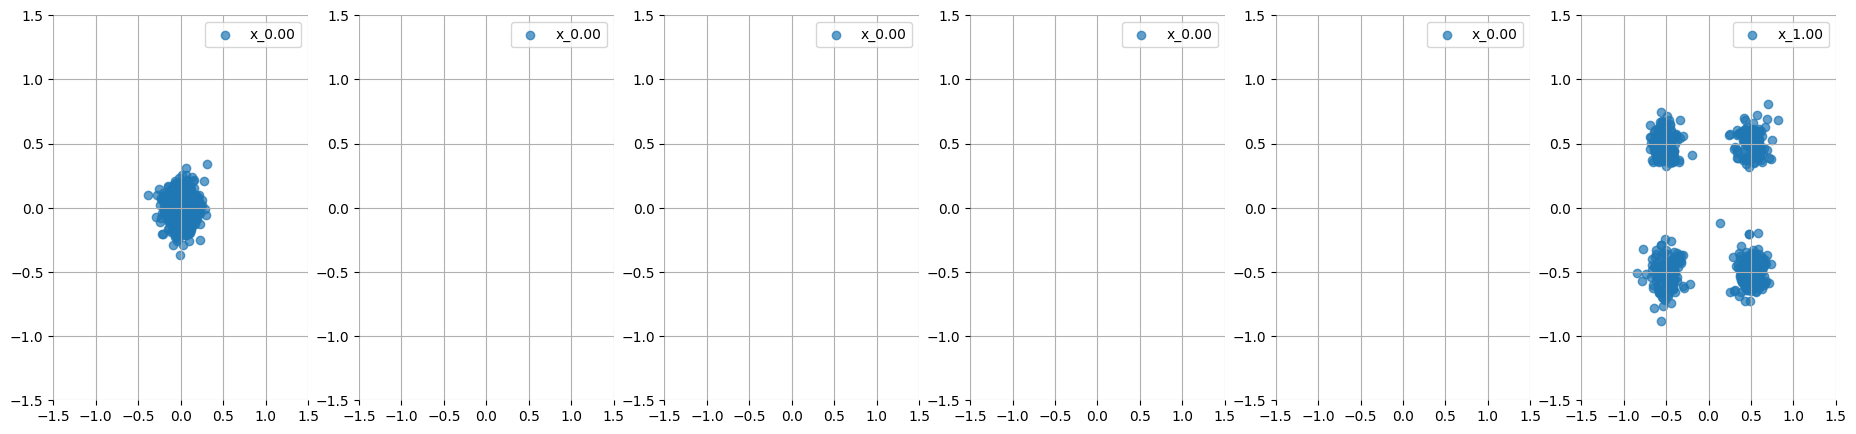

In [5]:
figsize(23,5)
plot_dynamics(x_t, 'x')
plt.show()

In [6]:
class MLP(nn.Module):
  num_hid : int
  num_out : int

  def setup(self):
    self.linear1 = nn.Dense(features=self.num_hid)
    self.linear2 = nn.Dense(features=self.num_hid)
    self.linear3 = nn.Dense(features=self.num_hid)
    self.linear4 = nn.Dense(features=self.num_out)

  def __call__(self, t, x):
    h = jnp.hstack([t,x])
    h = self.linear1(h)
    h = nn.relu(h)
    h = self.linear2(h)
    h = nn.relu(h)
    h = self.linear3(h)
    h = nn.relu(h)
    h = self.linear4(h)
    return h

In [7]:
def sample_t(u0, n, t0=0.0, t1=1.0):
  u = (u0 + math.sqrt(2)*np.arange(n + 1)) % 1
  u = u.reshape([-1,1])
  return u[:-1]*(t1-t0) + t0, u[-1]

In [8]:
model = MLP(num_hid=512, num_out=1)
print(model)

jseed, init_seed = random.split(jseed)
params = model.init(init_seed, x_t[0].t*np.ones([bs,1]), x_t[0].x)

optimizer = optax.adam(learning_rate=2e-4)
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=params,
                                      tx=optimizer)

# derivatives of the model are necessary to define the AM loss
dsdtdx_fn = jax.grad(lambda t, x, p: state.apply_fn(p,t,x).sum(), argnums=[0,1])
# and to apply the model
dsdx_fn = jax.grad(lambda t, x, p: state.apply_fn(p,t,x).sum(), argnums=1)

MLP(
    # attributes
    num_hid = 512
    num_out = 1
)


In [9]:
# def ot_loss(state, params, bs, u0, jseed):
#   # boundaries
#   t_0, t_1 = jnp.zeros([bs, 1]), jnp.ones([bs, 1])
#   x_0, x_1 = q_t(jseed, bs)
#   t, u0 = sample_t(u0, bs)

#   loss = state.apply_fn(params, t_0, x_0) - state.apply_fn(params, t_1, x_1)
#   solution = diffrax.diffeqsolve(
#       diffrax.ODETerm(dsdx_fn),
#       diffrax.Euler(),
#       t0=0.0,
#       t1=1.0,
#       dt0=1e-2,
#       y0=x_0,
#       stepsize_controller=diffrax.ConstantStepSize(True),
#       saveat=diffrax.SaveAt(ts=jnp.linspace(0.0, 1.0, 101)),
#       args=params,
#       adjoint=diffrax.BacksolveAdjoint()
#       )
#   x_t = solution.ys[jnp.round(100*t.ravel()).astype(int), jnp.arange(bs), :]
#   dsdt, dsdx = dsdtdx_fn(t.reshape([-1,1]),jax.lax.stop_gradient(x_t),params)
#   loss += dsdt + 0.5*(dsdx**2).sum(1, keepdims=True)
#   dsdt, dsdx = dsdtdx_fn(t.reshape([-1,1]),x_t,jax.lax.stop_gradient(params))
#   loss -= dsdt + 0.5*(dsdx**2).sum(1, keepdims=True)
#   return loss.mean(), u0

def ot_loss(state, params, bs, u0, jseed):
  # boundaries
  t_0, t_1 = jnp.zeros([bs, 1]), jnp.ones([bs, 1])
  x_0, x_1 = q_t(jseed, bs)
  t, u0 = sample_t(u0, bs)

  timeline = jnp.linspace(0.0, 1.0, 101)
  # intergration forward
  def dxdt(prev_state, next_t):
    _t, _x = prev_state.t, prev_state.x
    next_x = _x + (next_t-_t)*dsdx_fn(_t*jnp.ones([bs, 1]), _x, params)
    next_x = jax.lax.stop_gradient(next_x)
    return TimedX(t=next_t, x=next_x), next_x
  forward_solution = jax.lax.scan(dxdt, TimedX(t=0.0, x=x_0), timeline[1:])[1]
  forward_solution = jnp.vstack([jnp.expand_dims(x_0, 0), forward_solution])

  # integration backward
  def time_loss_fn(t_, x_, params):
    dsdt, dsdx = dsdtdx_fn(t_*jnp.ones([bs,1]),x_,params)
    return (dsdt + 0.5*(dsdx**2).sum(1, keepdims=True)).sum()

  deldx_fn = jax.grad(time_loss_fn, argnums=1)

  def dlambdadt(prev_state, _state):
    _t, _lambda = prev_state.t, prev_state.x
    next_t, _x = _state
    zero_params = jax.tree_map(lambda _p: jnp.zeros_like(_p), params)
    _, d2sdx2 = jax.jvp(dsdx_fn, (_t*jnp.ones([bs,1]),_x,params), (jnp.zeros([bs,1]),_lambda,zero_params))
    next_lambda = _lambda + (next_t - _t)*(deldx_fn(_t, _x, params) - d2sdx2)
    next_lambda = jax.lax.stop_gradient(next_lambda)
    return TimedX(t=next_t, x=next_lambda), next_lambda

  lambda_0 = jnp.zeros_like(x_0)
  backward_solution = jax.lax.scan(dlambdadt, TimedX(t=1.0, x=lambda_0), (timeline[::-1][1:], forward_solution[::-1][:-1]))[1]
  backward_solution = jnp.vstack([jnp.expand_dims(lambda_0, 0), backward_solution])
  backward_solution = backward_solution[::-1]
  
  t_ids = jnp.round(100*t.ravel()).astype(int)
  x_t = forward_solution[t_ids, jnp.arange(bs), :]
  lambd_t = backward_solution[t_ids, jnp.arange(bs), :]
  loss = (state.apply_fn(params, t_0, x_0) - state.apply_fn(params, t_1, x_1)).mean()
  dsdt, dsdx = dsdtdx_fn(t.reshape([-1,1]), x_t, params)
  loss += (dsdt + 0.5*(dsdx**2).sum(1, keepdims=True)).mean()
  loss += -(dsdx*lambd_t).sum(1, keepdims=True).mean()
  return loss, u0

@partial(jax.jit, static_argnums=1)
def train_step(state, bs, u0, jseed):
  grad_fn = jax.value_and_grad(ot_loss, argnums=1, has_aux=True)
  (loss, u0), grads = grad_fn(state, state.params, bs, u0, jseed)
  state = state.apply_gradients(grads=grads)
  return state, loss, u0

jseed, loc_seed = random.split(jseed)
# print(ot_loss(state, params, bs, 0.5, jseed))
# print(ot_loss_single(params, np.ones(2), np.ones(2), np.ones(1)))
state, loss, u0 = train_step(state, bs, 0.5, loc_seed)

In [10]:
num_iterations = 5000
u0 = 0.5

loss_plot = np.zeros(num_iterations)
for iter in trange(num_iterations):
  jseed, loc_seed = random.split(jseed)
  state, loss, u0 = train_step(state, bs, u0, loc_seed)
  loss_plot[iter] = loss

100%|██████████| 5000/5000 [08:53<00:00,  9.38it/s]


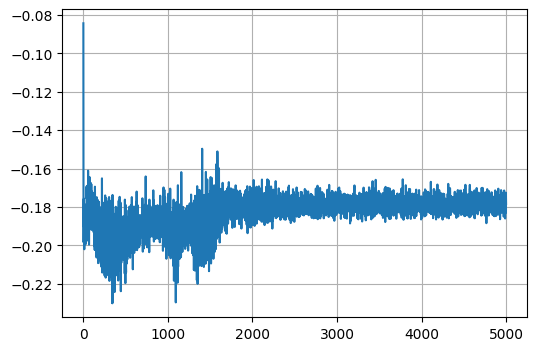

In [11]:
figsize(6,4)
plt.plot(loss_plot)
plt.grid()

In [12]:
dt = 1e-2
t_0 = 0.0
n = int(1/dt)
jseed, *loc_seed = random.split(jseed, num=3)
x = [TimedX(t=t_0, x=q_t(loc_seed[0], bs)[0])]
for _ in trange(n):
  x_ = x[-1].x + dt*dsdx_fn(x[-1].t*jnp.ones([bs,1]), x[-1].x, state.params)
  t_ = x[-1].t + dt
  x.append(TimedX(t=t_, x=x_))
  jseed, loc_seed = random.split(jseed)

100%|██████████| 100/100 [00:10<00:00,  9.93it/s]


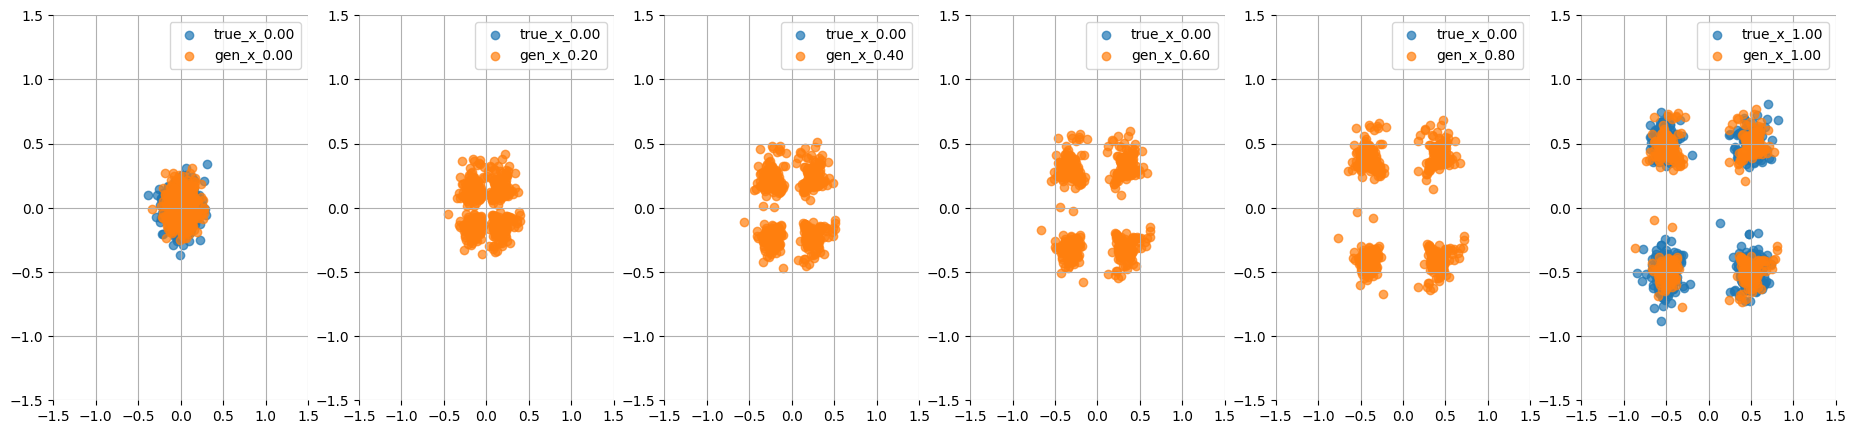

In [13]:
figsize(23,5)
ax = plot_dynamics(x_t, 'true_x')
_ = plot_dynamics(x[::20], 'gen_x', ax)
plt.show()

In [14]:
dt = 1e-2
t_0 = 0.0
n = int(1/dt)
jseed, loc_seed = random.split(jseed)
x = [TimedX(t=t_0, x=q_t(loc_seed, bs)[0])]
x.extend([TimedX(t=0.0, x=jnp.array([[[]]]))]*4)
x.append(TimedX(t=1.0, x=x[0].x + dsdx_fn(x[0].t*jnp.ones([bs,1]), x[0].x, state.params)))

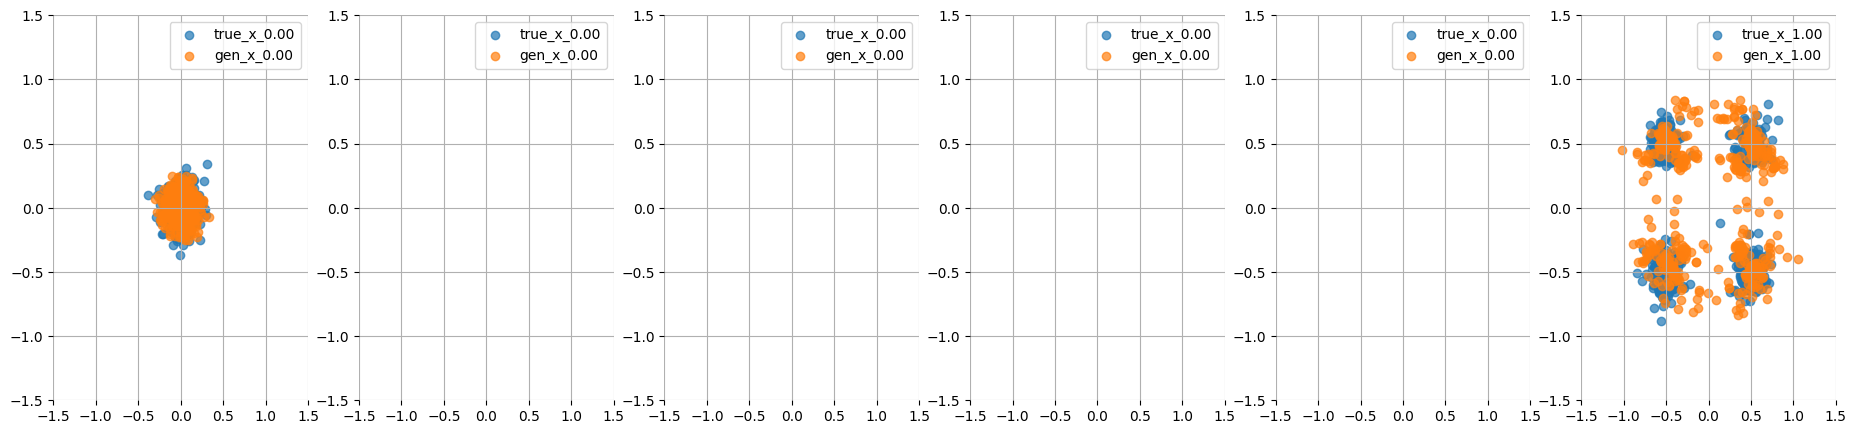

In [15]:
figsize(23,5)
ax = plot_dynamics(x_t, 'true_x')
_ = plot_dynamics(x, 'gen_x', ax)
plt.show()